In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

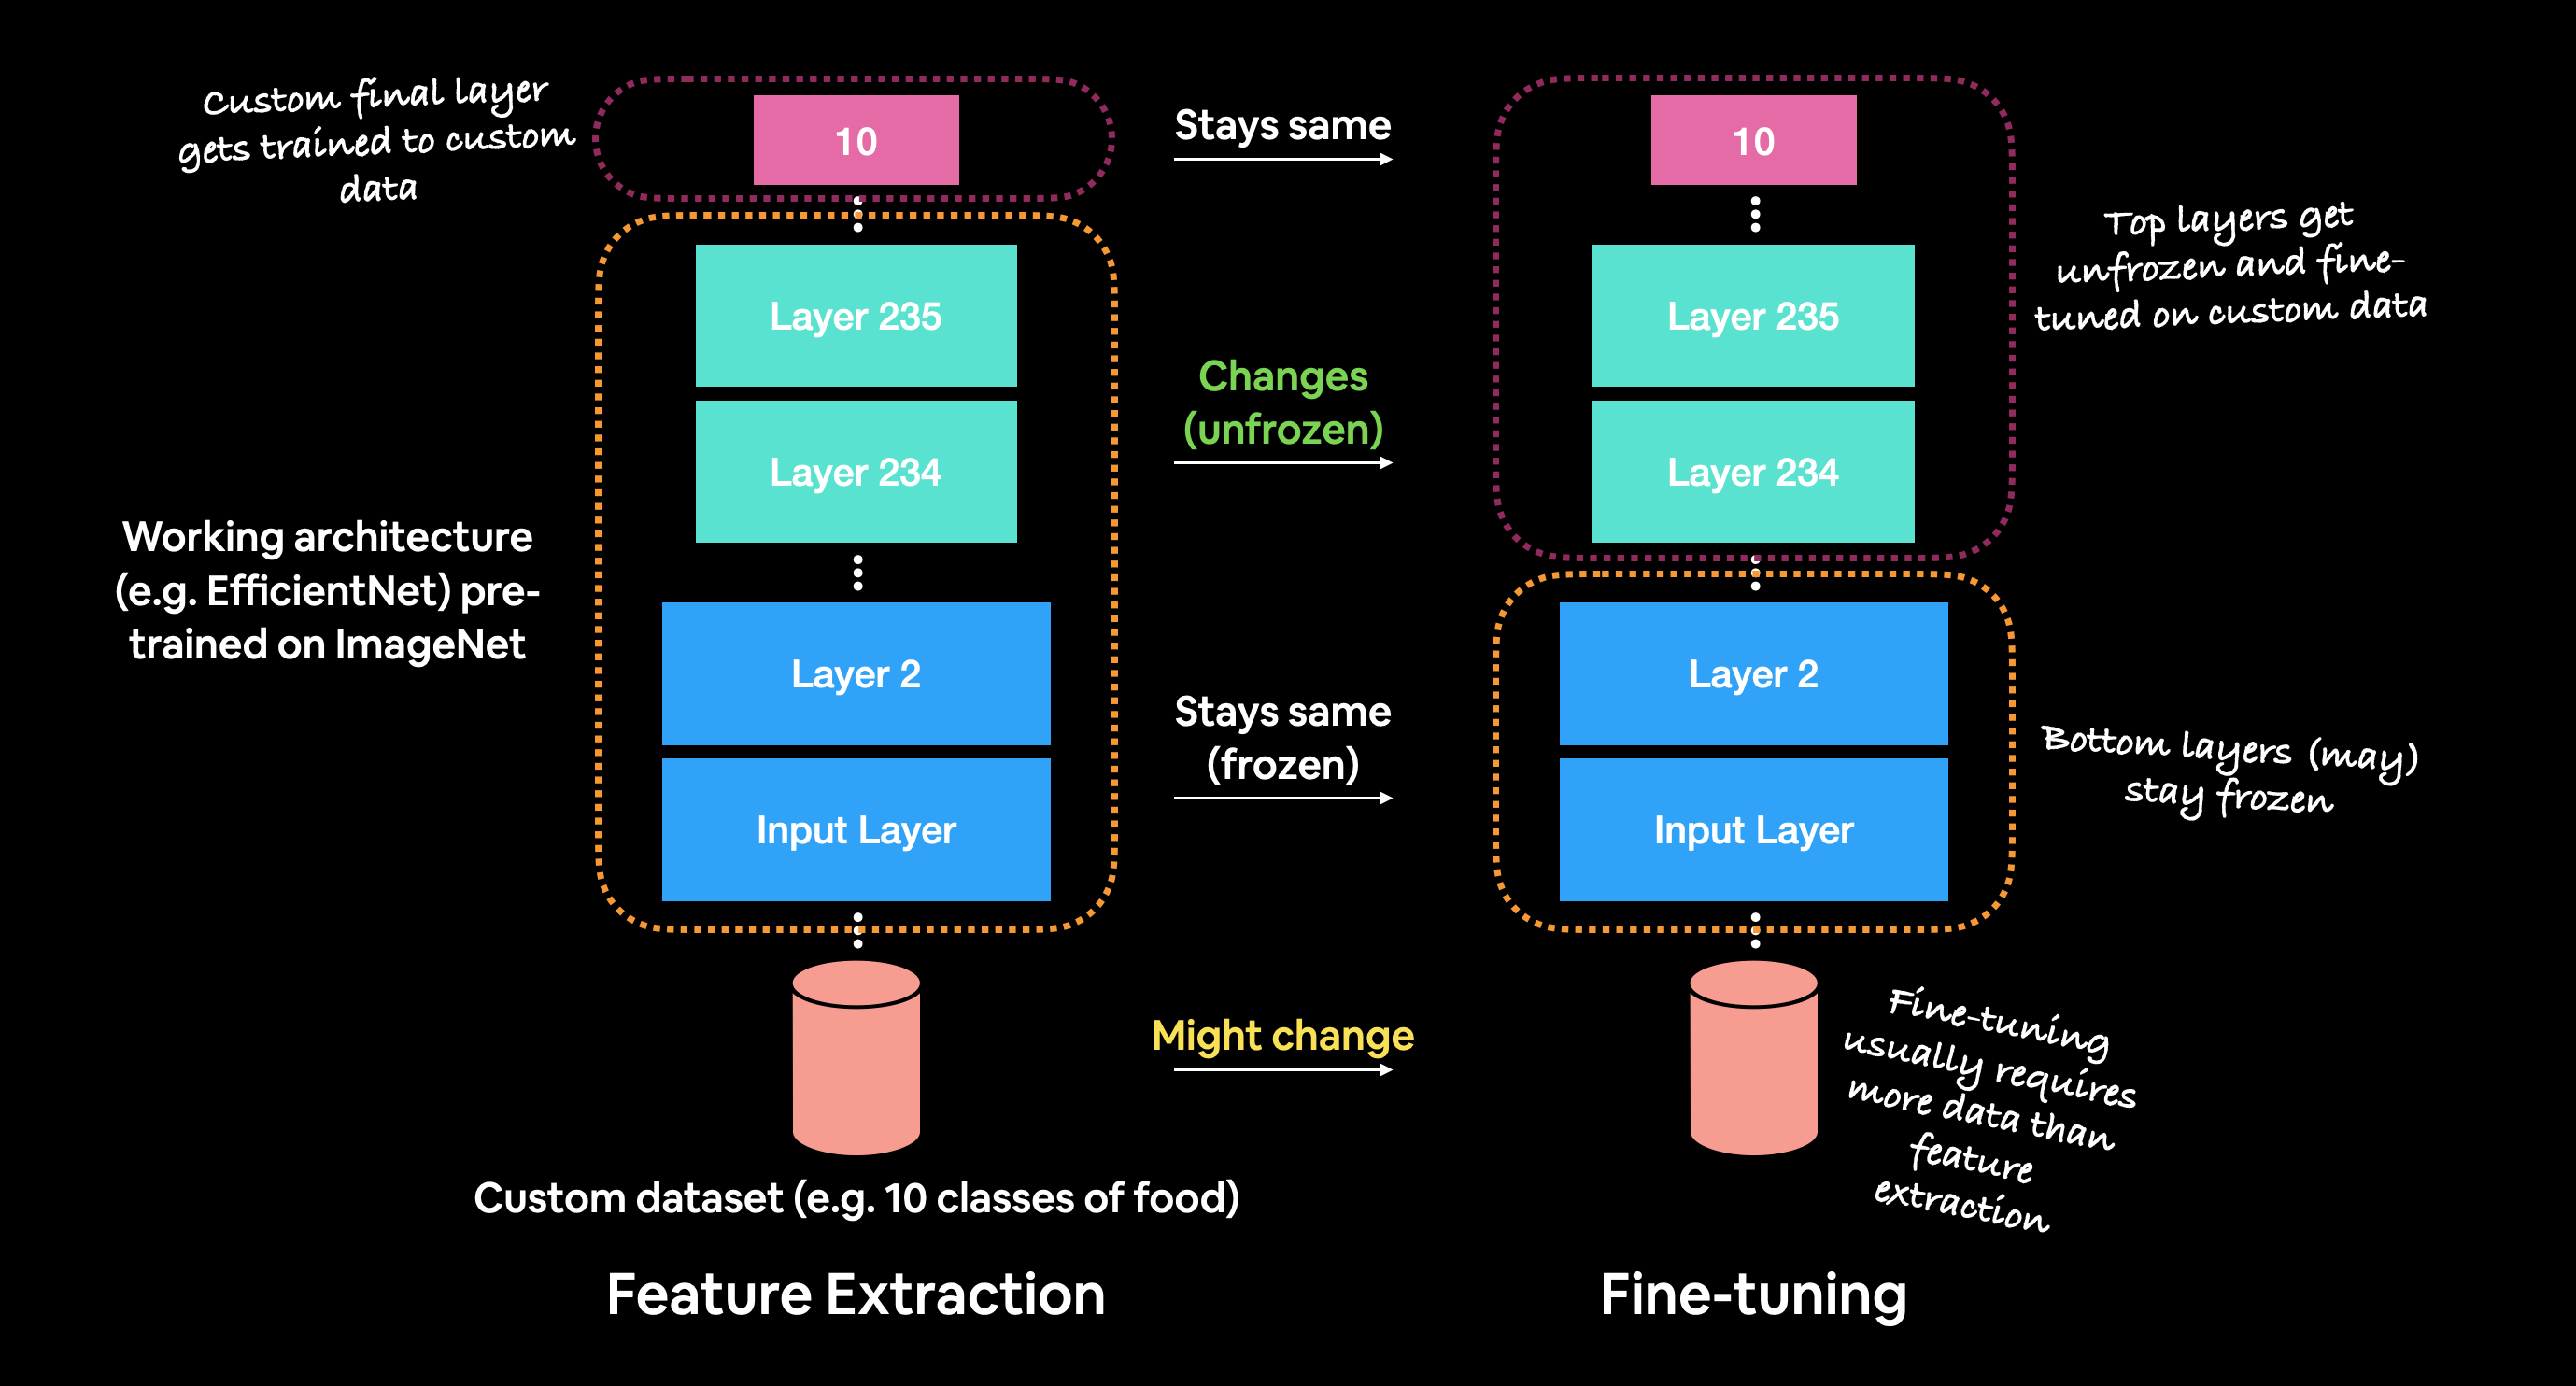

Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.

In [4]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-08-31 16:04:36.113473


In [5]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [6]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [7]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-08-31 16:04:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   205MB/s    in 0.8s    

2023-08-31 16:04:39 (205 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [9]:
# Create training and testing directories
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [10]:
# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = 32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
# Check the training data datatype
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.44770416e+02 2.45770416e+02 2.39770416e+02]
   [2.34311218e+02 2.35311218e+02 2.29311218e+02]
   [2.40433670e+02 2.41647964e+02 2.36647964e+02]
   ...
   [2.43852020e+02 2.43852020e+02 2.43852020e+02]
   [2.44571396e+02 2.44571396e+02 2.42571396e+02]
   [2.48158493e+02 2.48158493e+02 2.46158493e+02]]

  [[2.45000000e+02 2.46000000e+02 2.40000000e+02]
   [2.35709198e+02 2.36709198e+02 2.30709198e+02]
   [2.38943878e+02 2.40158157e+02 2.35158157e+02]
   ...
   [2.41285690e+02 2.41285690e+02 2.41285690e+02]
   [2.41928543e+02 2.41928543e+02 2.39928543e+02]
   [2.46214600e+02 2.46214600e+02 2.44214600e+02]]

  [[2.45142868e+02 2.46000000e+02 2.41357147e+02]
   [2.34285721e+02 2.35500015e+02 2.30500015e+02]
   [2.38357147e+02 2.39311234e+02 2.34448990e+02]
   ...
   [2.41428528e+02 2.41428528e+02 2.41428528e+02]
   [2.41658142e+02 2.41658142e+02 2.39658142e+02]
   [2.46571777e+02 2.46571777e+02 2.44571777e+02]]

  ...

  [[2.46857147e+02 2.47857147e+02 2.41857147e+02]
   [2

### Model 0: Building a transfer learning model using the Keras Functional API

In [14]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# 4. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 5. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = "output_layer")(x)

# 7. Combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 9. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks = [create_tensorboard_callback('transfer_learning', '10_percent_feature_extract')])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230831-160449
Epoch 1/5
24/24 [==============================] - 19s 77ms/step - loss: 1.9216 - accuracy: 0.4160
Epoch 2/5
24/24 [==============================] - 2s 66ms/step - loss: 1.1662 - accuracy: 0.7267
Epoch 3/5
24/24 [==============================] - 2s 65ms/step - loss: 0.8583 - accuracy: 0.8067
Epoch 4/5
24/24 [==============================] - 2s 67ms/step - loss: 0.6966 - accuracy: 0.8413
Epoch 5/5
24/24 [==============================] - 2s 72ms/step - loss: 0.6071 - accuracy: 0.8640


In [15]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [17]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


# Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

- Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

- Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.

- Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.

- Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and testing dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1 = "10_food_classes_1_percent/test/"

--2023-08-31 16:05:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   131MB/s    in 1.0s    

2023-08-31 16:05:30 (131 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

Time to load our images in as `tf.data.Dataset objects`, to do so, we'll use the `image_dataset_from_directory()` method.

In [20]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           batch_size = 32, #default
                                                                           image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Data loaded. Time to augment it.

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = 'data_augmentation')

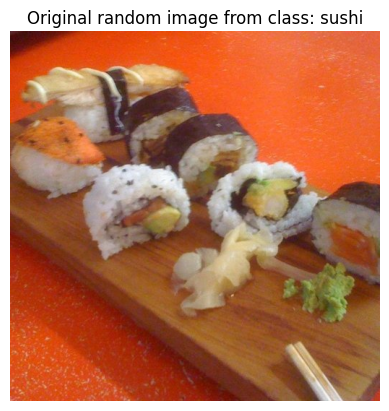

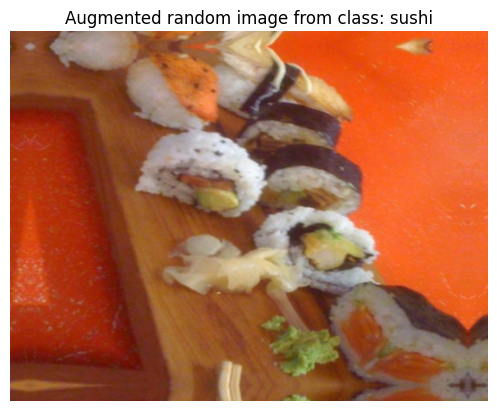

In [22]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

# Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = 'Input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = 'Global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = 'softmax', name = 'Output_layer')(x)

# Make a model with inputs and Outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)), #Validate for less steps
                                # Track model training logs
                                callbacks = [create_tensorboard_callback('transfer_learning', '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230831-160537
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.4050 - accuracy: 0.1000 - val_loss: 2.2160 - val_accuracy: 0.1924
Epoch 2/5
3/3 [==============================] - 8s 3s/step - loss: 2.1721 - accuracy: 0.1286 - val_loss: 2.1014 - val_accuracy: 0.2747
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9908 - accuracy: 0.3714 - val_loss: 1.9886 - val_accuracy: 0.3273
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.8534 - accuracy: 0.4000 - val_loss: 1.9060 - val_accuracy: 0.3816
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6582 - accuracy: 0.6429 - val_loss: 1.8141 - val_accuracy: 0.4211


Using only 7 training images per class, using transfer learning our model was able to get ~60%+ accuracy on the validation set.

In [24]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                           

In [25]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 77ms/step - loss: 1.8147 - accuracy: 0.4260


[1.8146544694900513, 0.4259999990463257]

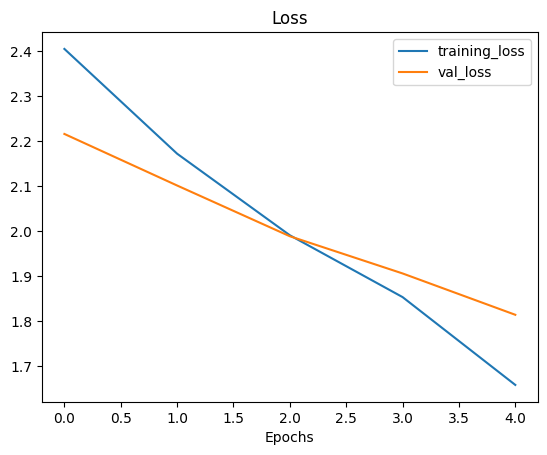

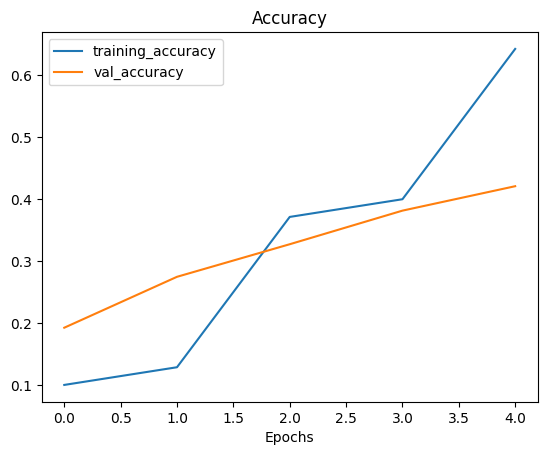

In [26]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

# Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [27]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [28]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [29]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = 'data_augmentation')

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape = input_shape, name = 'input_layer') # Create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),# use Adam optimizer with base learning rate
                metrics = ['accuracy'])

To save time for later (when we want to perform multiple experiments with `model_2`), let's put the code above into a function we can resuse.

In [30]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

# Creating a ModelCheckpoint callback

In [31]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [32]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230831-160641
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9978 - accuracy: 0.3467
Epoch 1: val_loss improved from inf to 1.55157, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 932ms/step - loss: 1.9978 - accuracy: 0.3467 - val_loss: 1.5516 - val_accuracy: 0.6250
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4064 - accuracy: 0.6507
Epoch 2: val_loss improved from 1.55157 to 1.10065, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 817ms/step - loss: 1.4064 - accuracy: 0.6507 - val_loss: 1.1006 - val_accuracy: 0.7418
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1043 - accuracy: 0.7147
Epoch 3: val_loss improved from 1.10065 to 0.89561, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

Let's evaluate our model and check its loss curves.

In [33]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 0.6749 - accuracy: 0.8156


[0.6749011874198914, 0.8155999779701233]

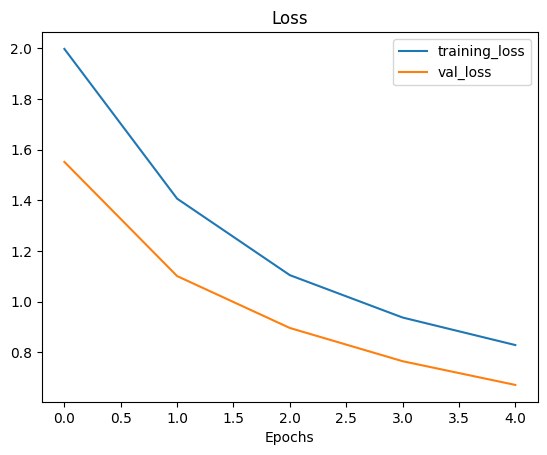

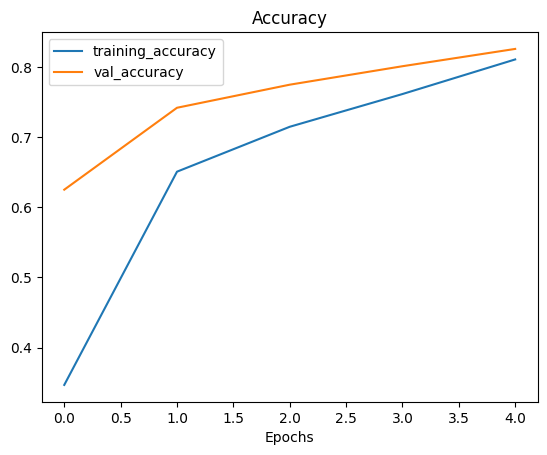

In [34]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [35]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6749 - accuracy: 0.8156


In [36]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

However, they should be very close...

In [37]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [38]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


# Model 3: Fine-tuning an existing model on 10% of the data

In [39]:
# Layers in loaded model
model_2.layers

In [40]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x7ff9c2d769e0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x7ff9c37c3220> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x7ff9bc2b72e0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ff9bc2793f0> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x7ff9b4121bd0> | Trainable? True


In [41]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [42]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [43]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


In [44]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [45]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all the layers except the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), #lr is 10x lower than before for fine-tuning
                metrics = ['accuracy'])

now let's check which layers of the pretrained model are trainable.

In [46]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

In [47]:
print(len(model_2.trainable_variables))

12


In [48]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_layers"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_layers/20230831-160907
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.7947
Epoch 5: val_loss improved from 0.67074 to 0.58536, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 680ms/step - loss: 0.7364 - accuracy: 0.7947 - val_loss: 0.5854 - val_accuracy: 0.8043
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.8267
Epoch 6: val_loss improved from 0.58536 to 0.54752, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 634ms/step - loss: 0.6058 - accuracy: 0.8267 - val_loss: 0.5475 - val_accuracy: 0.8109
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.8347
Epoch 7: val_loss improved from 0.54752 to 0.48924, saving model to ten_percent_model_checkpoints_weights/chec

 our model has gained a few percentage points of accuracy! Let's evalaute it.

In [49]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3466666638851166, 0.6506666541099548, 0.7146666646003723, 0.7613333463668823, 0.8106666803359985, 0.7946666479110718, 0.8266666531562805, 0.8346666693687439, 0.8533333539962769, 0.843999981880188, 0.8706666827201843]


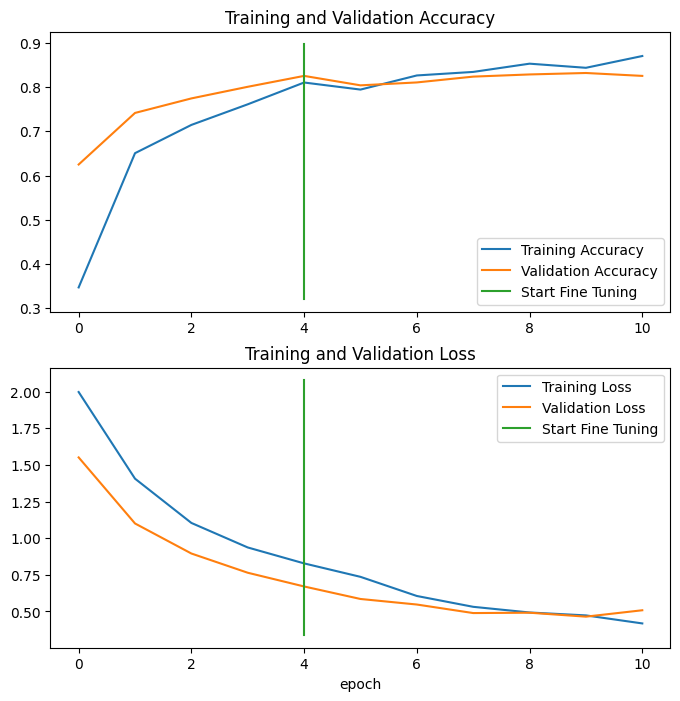

In [50]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

# Model 4: Fine-tuning an existing model all of the data

We'll start by downloading the full version of our 10 food classes dataset.

In [51]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-08-31 16:11:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  28.3MB/s    in 5.4s    

2023-08-31 16:11:11 (91.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [52]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [53]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.


In [54]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.4643 - accuracy: 0.8420


[0.4642707109451294, 0.8420000076293945]

In [55]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [56]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [57]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [58]:
print(len(model_2.trainable_variables))

2


In [59]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 67ms/step - loss: 0.4510 - accuracy: 0.8432


[0.45104336738586426, 0.8432000279426575]

In [60]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [61]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [62]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

The last 10 layers are trainable (unfrozen).

In [63]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [64]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last/20230831-161151
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7860
Epoch 5: val_loss improved from 0.46477 to 0.36866, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 97s 370ms/step - loss: 0.6626 - accuracy: 0.7860 - val_loss: 0.3687 - val_accuracy: 0.8602
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.8109
Epoch 6: val_loss improved from 0.36866 to 0.36225, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 74s 312ms/step - loss: 0.5813 - accuracy: 0.8109 - val_loss: 0.3622 - val_accuracy: 0.8717
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.8257
Epoch 7: val_loss improved from 0.36225 to 0.30020, saving model to ten_percent_model_checkpoints_weig

In [65]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 70ms/step - loss: 0.2640 - accuracy: 0.9132


[0.2639736235141754, 0.9132000207901001]

5
11
[0.3466666638851166, 0.6506666541099548, 0.7146666646003723, 0.7613333463668823, 0.8106666803359985, 0.7860000133514404, 0.8109333515167236, 0.8257333040237427, 0.8371999859809875, 0.8497333526611328, 0.8600000143051147]


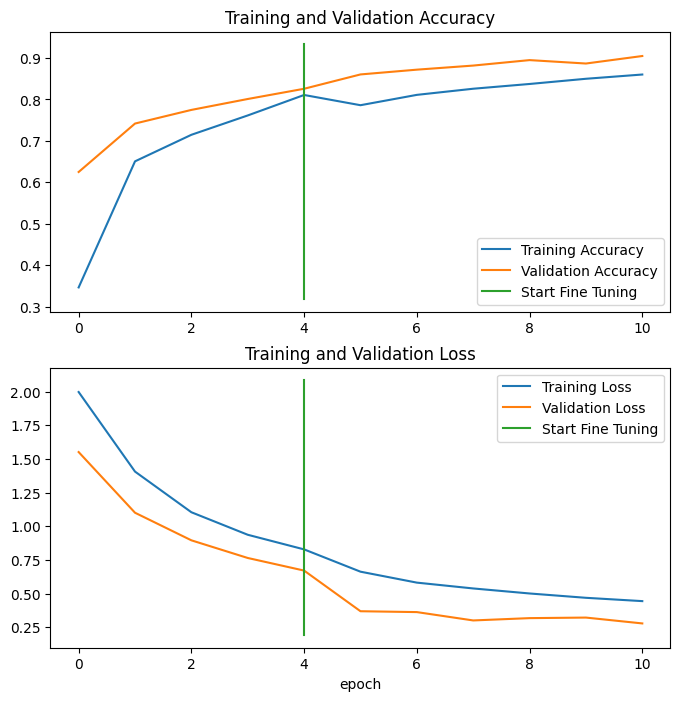

In [66]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

# Viewing our experiment data on TensorBoard

In [70]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2023-08-31 16:38:51.854280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/u2SXx8RcRkSl4bGYUv4EMA/

[2023-08-31T16:38:54] Started scanning logdir.
[2023-08-31T16:38:59] Total uploaded: 142 scalars, 0 tensors, 5 binary objects (4.9 MB)
[2023-08-31T16:38:59] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/u2SXx8RcRkSl4bGYUv4EMA/


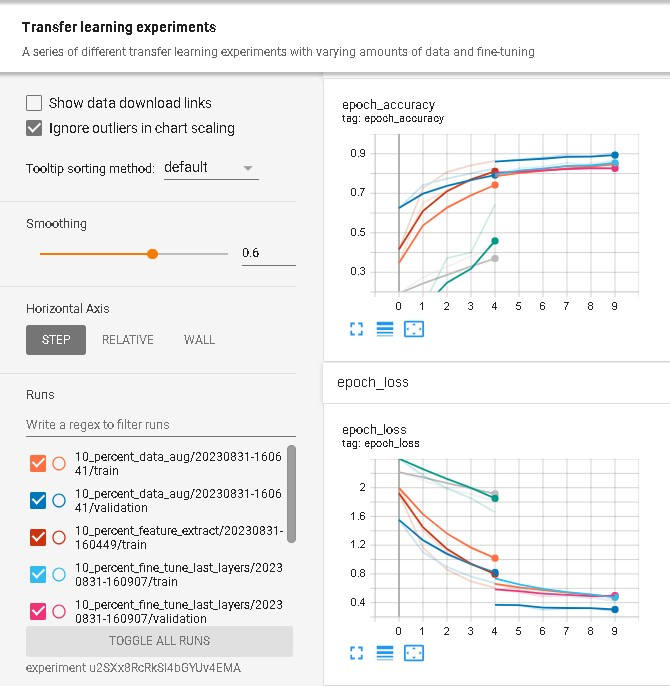